BERT

In [13]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [14]:
# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [15]:
#Load data
df = pd.read_excel("/home/aayushivt/Master_thesis/finalized_data.xlsx")
df.shape

(14572, 8)

In [16]:
df.head()

,Id,user_id,ship_id,datetime,score,feedback,feedback_english,cleaned_feedback
0,1,55284,0,2022-06-07 09:00:00,1,I paid for it and it doesnâ€™t work.,I paid for it and it doesnâ€™t work.,I paid for it and it doesnt work
1,2,55318,1,6/7/2022 12:55,1,DÃ¥rlig dekkning!,Bad coverage!,Bad coverage
2,3,55341,2,6/7/2022 14:56,1,Voucher code doesnâ€™t seem to work,Voucher code doesnâ€™t seem to work,Voucher code doesnt seem to work
3,4,55342,2,6/7/2022 14:57,1,"No free WiFi available in cabins, unable to bu...","No free WiFi available in cabins, unable to bu...",No free WiFi available in cabins unable to buy...
4,5,55347,3,6/7/2022 11:51,3,Ja,Yes,Yes


In [17]:
#check for missing values 
df.isnull().sum()

Id                  0
user_id             0
ship_id             0
datetime            0
score               0
feedback            0
feedback_english    1
cleaned_feedback    0
dtype: int64

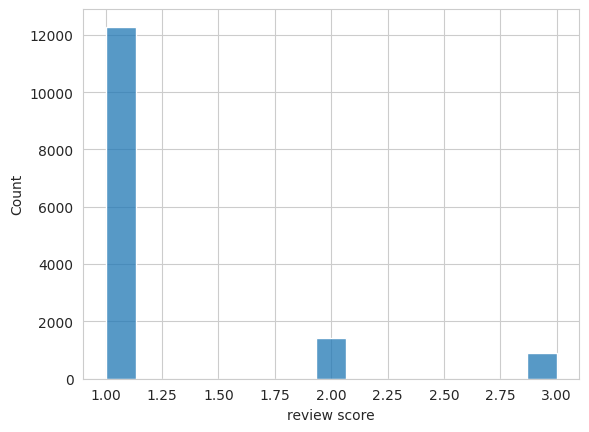

In [18]:
sns.set_style("whitegrid")

# Plot the histogram with grid
sns.histplot(data=df, x="score")
plt.xlabel('review score')
plt.show()

In [19]:
# Function to convert score to sentiment
def to_sentiment(rating):
    
    rating = int(rating)
    
    # Convert to class
    if rating <= 1.25:
        return 0
    elif rating == 2:
        return 1
    else:
        return 2

# Apply to the dataset 
df['sentiment'] = df.score.apply(to_sentiment)

In [20]:
# # Plot the distribution
# class_names = ['negative', 'neutral', 'positive']
# ax = sns.histplot(df.sentiment)
# plt.xlabel('review sentiment')
# ax.set_xticklabels(class_names)

In [21]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [22]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [23]:
# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in df.cleaned_feedback:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

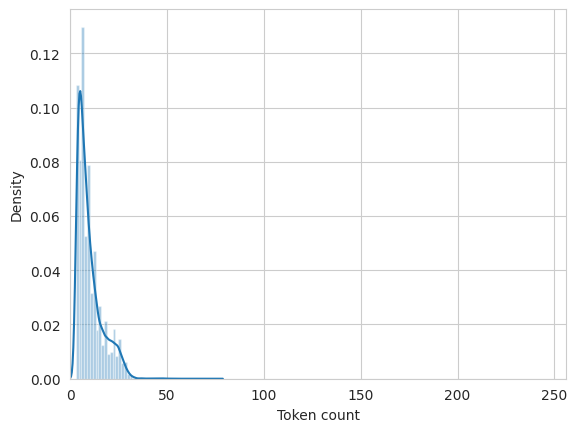

In [24]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [25]:
MAX_LEN = 100

Preparing Torch Dataset¶
To enter data into a PyTorch, we need a more robust data generator class. We will return the review text as well to validate our predictions easily.

In [26]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

Create a 80% train data and 10% test and 10% validation data



In [27]:
RANDOM_SEED=42
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(11657, 9) (1457, 9) (1458, 9)


Create a dataloader to release data in batches

In [28]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.cleaned_feedback.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [29]:
# Create train, test and val data loaders
BATCH_SIZE = 8
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [30]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([8, 100])
torch.Size([8, 100])
torch.Size([8])


Sentiment Classification with BERT and Hugging Face ...
We’ll use the basic BertModel and build our sentiment classifier on top of it. Let’s load the model

In [31]:
#Load the basic BERT model 
bert_model = BertModel.from_pretrained(MODEL_NAME)

In [32]:
# Build the Sentiment Classifier class 
import torch.nn.functional as F

class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.5)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagation method
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.pooler_output  # Use pooler_output instead of _, pooled_output
        # Apply dropout
        output = self.drop(pooled_output)
        return self.out(output)

We use a dropout layer for some regularization and a fully-connected layer for our output. We are returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work. Create an instance and move it to the GPU

In [33]:
# Instantiate the model and move to classifier
class_names = ['negative', 'neutral', 'positive']
model = SentimentClassifier(len(class_names))
model = model.to(device)
#model

In [34]:
#Model Characterstics
# Number of hidden units
print(bert_model.config.hidden_size)

768


#Training Phase
#we’ll use the AdamW optimizer provided by Hugging Face. It corrects weight decay. We’ll also use a linear scheduler with no warmup

In [35]:
# Number of iterations 
EPOCHS = 10

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False) #, weight_decay=0.01)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [36]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [37]:
#function to evaluate model performance

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [38]:
#Write the training Loop and store the best training state.

#%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), '10epbest_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.5259062549602674 accuracy 0.8412112893540361
Val   loss 0.44780322133761935 accuracy 0.8730267673301304

Epoch 2/10
----------
Train loss 0.46162446578951816 accuracy 0.862400274513168
Val   loss 0.4674413781816679 accuracy 0.8778311599176389

Epoch 3/10
----------
Train loss 0.4116074584708108 accuracy 0.8754396499957107
Val   loss 0.543041908016805 accuracy 0.8716540837336993

Epoch 4/10
----------
Train loss 0.3757243412677761 accuracy 0.896800205884876
Val   loss 0.6097966634256186 accuracy 0.8634179821551132

Epoch 5/10
----------
Train loss 0.3281015073926864 accuracy 0.91635926910869
Val   loss 0.7160725216152238 accuracy 0.8558682223747426

Epoch 6/10
----------
Train loss 0.2985603361642365 accuracy 0.9294844299562494
Val   loss 0.7703927252174462 accuracy 0.8586135895676046

Epoch 7/10
----------
Train loss 0.2691611906416 accuracy 0.9379771810929055
Val   loss 0.8119094125644044 accuracy 0.8531228551818806

Epoch 8/10
----------
Train loss 

In [40]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8559670781893004

In [41]:
#Define a helper function to get predictions from our models. This is similar to the evaluation function,
#except that we’re storing the text of the reviews and the predicted probabilities

def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.91      0.95      0.93      1245
     neutral       0.38      0.22      0.27       144
    positive       0.51      0.58      0.54        69

    accuracy                           0.86      1458
   macro avg       0.60      0.58      0.58      1458
weighted avg       0.84      0.86      0.84      1458



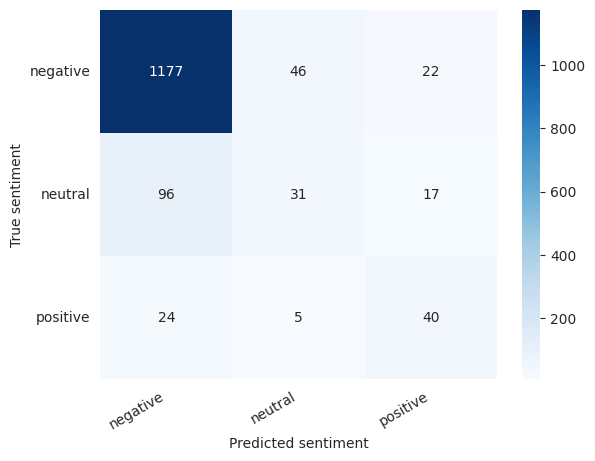

In [42]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [43]:
#Prediction

review_text = "I can not pay cause no internet"

In [44]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [45]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I can not pay cause no internet
Sentiment  : negative
